In [1]:
import pandas as pd
import re
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [5]:
# Download NLTK data files
# nltk.download('stopwords')
# nltk.download('wordnet')
#nltk.download('punkt')

In [6]:
# Load the dataset
df = pd.read_csv('spam.csv', encoding='latin-1')
df = df.rename(columns={'v1': 'category', 'v2': 'text'})
df = df[['category', 'text']]

Dataset description

In [7]:
 # Display the first five rows of the dataset
print(df.head(10))

  category                                               text
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
5     spam  FreeMsg Hey there darling it's been 3 week's n...
6      ham  Even my brother is not like to speak with me. ...
7      ham  As per your request 'Melle Melle (Oru Minnamin...
8     spam  WINNER!! As a valued network customer you have...
9     spam  Had your mobile 11 months or more? U R entitle...


In [8]:
# Display basic statistics
print(df.describe())

       category                    text
count      5572                    5572
unique        2                    5169
top         ham  Sorry, I'll call later
freq       4825                      30


In [9]:
# Display dataset information
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  5572 non-null   object
 1   text      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None


In [10]:
df.shape

(5572, 2)

Split the Data into Training and Test Sets

In [11]:
from sklearn.model_selection import train_test_split

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['category'], test_size=0.2, random_state=42, stratify=df['category'])

# Print the number of samples in the training and testing sets
print(f'The size of training data is: {X_train.shape[0]}')
print(f'The size of testing data is: {X_test.shape[0]}')

The size of training data is: 4457
The size of testing data is: 1115


Exploratory data analysis

In [12]:
# Display category distribution
print(df['category'].value_counts())

category
ham     4825
spam     747
Name: count, dtype: int64


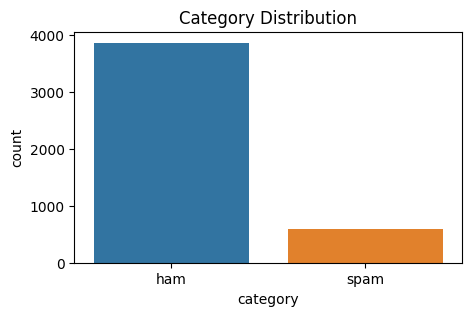

In [13]:
# Visualize Category Distribution

# Combine X_train and y_train
train_df = pd.DataFrame({'text': X_train, 'category': y_train})

# Plot category distribution
plt.figure(figsize=(5, 3))
sns.countplot(x='category', data=train_df)
plt.title('Category Distribution')
plt.show()

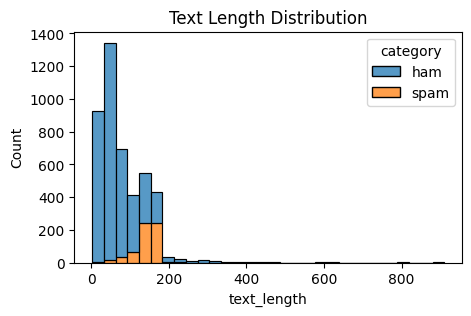

           count        mean        std   min    25%    50%    75%    max
category                                                                 
ham       3859.0   70.829749  57.966498   2.0   33.0   52.0   91.0  910.0
spam       598.0  139.147157  28.887904  13.0  133.0  149.0  158.0  224.0


In [14]:
# Text Length Analysis

# Add a new column for text length
train_df['text_length'] = train_df['text'].apply(len)

# Plot text length distribution
plt.figure(figsize=(5, 3))
sns.histplot(data=train_df, x='text_length', hue='category', multiple='stack', bins=30)
plt.title('Text Length Distribution')
plt.show()

# Descriptive statistics of text length
print(train_df.groupby('category')['text_length'].describe())

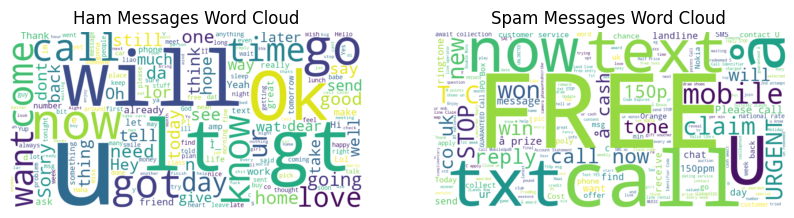

In [15]:
# Word Cloud for Text Visualization

# Generate word clouds for ham and spam messages
ham_words = ' '.join(train_df[train_df['category'] == 'ham']['text'])
spam_words = ' '.join(train_df[train_df['category'] == 'spam']['text'])

# Create word clouds
ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_words)
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_words)

# Plot word clouds
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Ham Messages Word Cloud')

plt.subplot(1, 2, 2)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Spam Messages Word Cloud')

plt.show()

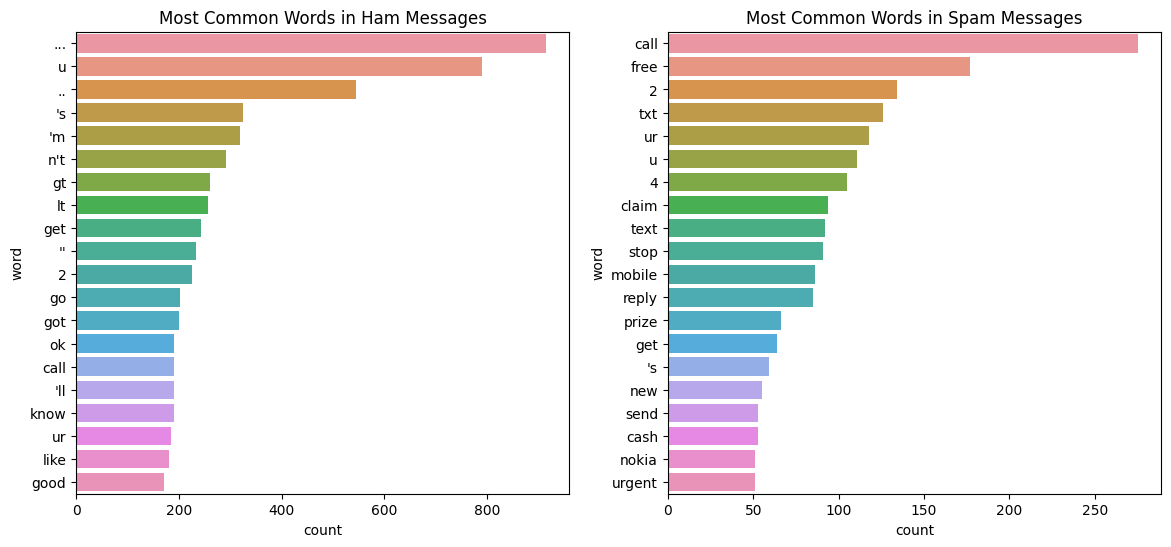

In [16]:
# Common Words in Ham and Spam Messages

# Define stop words and punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

def process_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove stop words and punctuation
    tokens = [word for word in tokens if word not in stop_words and word not in punctuation]
    return tokens

# Process texts for ham and spam messages
ham_tokens = train_df[train_df['category'] == 'ham']['text'].apply(process_text)
spam_tokens = train_df[train_df['category'] == 'spam']['text'].apply(process_text)

# Flatten the list of lists
ham_words = [word for tokens in ham_tokens for word in tokens]
spam_words = [word for tokens in spam_tokens for word in tokens]

# Get the most common words
ham_common_words = Counter(ham_words).most_common(20)
spam_common_words = Counter(spam_words).most_common(20)

# Plot the most common words
ham_common_df = pd.DataFrame(ham_common_words, columns=['word', 'count'])
spam_common_df = pd.DataFrame(spam_common_words, columns=['word', 'count'])

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='count', y='word', data=ham_common_df)
plt.title('Most Common Words in Ham Messages')

plt.subplot(1, 2, 2)
sns.barplot(x='count', y='word', data=spam_common_df)
plt.title('Most Common Words in Spam Messages')

plt.show()